# This is the final project. Let's see whics restraunt type in the center of Moscow is better for an investor.

### Importing libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import requests
import io
import lxml
import json

In [2]:
import geocoder # import geocoder

In [3]:
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

## Let's see the map first

In [4]:
msk_lat = 55.754565
msk_lon = 37.619345
zoom = 13.5

In [5]:
map_msk = folium.Map(location=[msk_lat,msk_lon], zoom_start=zoom)
map_msk

In [6]:
cl_id = 'K4MIV0MO4SW5MCILZEWGCLOCXXFCHQ2RLRW2OGWF0KFJDCOM'
cl_se = 'FDHN1TGRI1VEEABZWEEPFD1VBSWBK15MLIEVVC3TGDCGGRGK'

### Let's define some helping functions

In [7]:
def get_venue_placeType(lat,lng,placeType,_radius,_limit):
    url = 'https://api.foursquare.com/v2/venues/explore'
    params = dict(
    client_id=cl_id,
    client_secret=cl_se,
    v='20180323',
    ll=str(msk_lat) + ',' + str(msk_lon),
    query=str(placeType),
    radius=_radius,
    limit=_limit
    )

    resp = requests.get(url=url, params=params)
    data = resp.json()["response"]['groups'][0]['items']
    #print(data)

    details=[]
    for r in data:
        try:
            r_id=r['venue']['id']
            r_name=r['venue']['name']
            r_category=r['venue']['categories'][0]['name']
            r_short=r['venue']['categories'][0]['shortName']
            r_lat=r['venue']['location']['lat']
            r_lon=r['venue']['location']['lng']
            details.append([r_id,r_name,r_category,r_short,r_lat,r_lon,0,0,0])
        except KeyError:
            pass
    column_names=['ID','Name','Category','Short','LAT','LON','Likes','Rating','Tips']
    df = pd.DataFrame(details,columns=column_names)
    return df

In [8]:
def get_venue_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/'+str(venue_id)
    params = dict(
    client_id=cl_id,
    client_secret=cl_se,
    v='20180323'
    )

    resp = requests.get(url=url, params=params)
    #print(resp.json())
    data = resp.json()['response']['venue']
    #print(data)

    details=[]
    try:
        r_id=data['id']
        r_name=data['name']
        r_likes=data['likes']['count']
        r_rating=data['rating']
        r_tips=data['tips']['count']
        details.append([r_id,r_name,r_likes,r_rating,r_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(details,columns=column_names)
    return df


In [9]:
def fill_venues_with_details(df):
    sh = df_pizza.shape[0]
    for i in range(sh):
        #print(df_pizza['ID'][i])
        df2 = get_venue_details(df['ID'][i])
        df['Likes'][i] = df2['Likes'][0]
        df['Rating'][i] = df2['Rating'][0]
        df['Tips'][i] = df2['Tips'][0]

In [10]:
def fill_venues_random(df):
    sh = df_pizza.shape[0]
    for i in range(sh):
        #print(df_pizza['ID'][i])
        #df2 = get_venue_details(df_pizza['ID'][i])
        df['Likes'][i] = np.random.randint(0,1000)
        df['Rating'][i] = np.random.randint(0,10)
        df['Tips'][i] = np.random.random()*1000

### Setting Parameters

In [11]:
radius = 5000
limit = 100

### Getting PIZZA, SUSHI and RUSSIAN restraunts data

In [12]:
df_pizza = get_venue_placeType(msk_lat,msk_lon,"pizza", radius, limit)

In [13]:
df_sushi = get_venue_placeType(msk_lat,msk_lon,"sushi", radius, limit)

In [14]:
df_rus = get_venue_placeType(msk_lat,msk_lon,"Russian", radius, limit)

## Filling venues with venue data
### We will also normalize Tips, saving Tips Max
#### fill_venues_random left for compatibility (if I will exceed the quota)

In [15]:
fill_venues_random(df_pizza)
fill_venues_random(df_sushi)
fill_venues_random(df_rus)

In [16]:
#fill_venues_with_details(df_pizza)
#fill_venues_with_details(df_sushi)
#fill_venues_with_details(df_rus)

In [17]:
tips_pizza_max = max(df_pizza['Tips']) 
df_pizza['Tips'] = df_pizza['Tips']/tips_pizza_max
df_pizza.head()

,ID,Name,Category,Short,LAT,LON,Likes,Rating,Tips
0,59be341a9cadd90e7e05adbc,Camorra Pizza e Birra,Pizza Place,Pizza,55.755135,37.636913,962,7,0.785356
1,546e146b498e86d7178d336d,Pinzeria by Bontempi,Pizza Place,Pizza,55.746038,37.602141,346,9,0.593781
2,59dcac56da2e0054b468441e,Il Pizzaiolo,Pizza Place,Pizza,55.756817,37.621677,688,7,0.982949
3,59a01396037be1415cee1310,Pinsa Maestrello,Pizza Place,Pizza,55.758779,37.645721,378,1,0.785356
4,5a366203838e5972571a9eed,Pinzeria by Bontempi,Pizza Place,Pizza,55.766728,37.624124,345,5,0.003009


In [18]:
tips_sushi_max = max(df_sushi['Tips']) 
df_sushi['Tips'] = df_sushi['Tips']/tips_sushi_max
df_sushi.head()

,ID,Name,Category,Short,LAT,LON,Likes,Rating,Tips
0,51cefa43498ebe6beaa060d9,Novikov,Asian Restaurant,Asian,55.757512,37.612967,638,6,0.864322
1,5ba3a67ead910e002c645e8c,Ки-До,Sushi Restaurant,Sushi,55.747378,37.597697,698,6,0.467337
2,57c027d7498e8532054695f3,Corner Café & Kitchen,Japanese Restaurant,Japanese,55.751496,37.586757,106,7,0.416080
3,59248954a4ba7c7d5af54ff4,Buba by Sumosan,Sushi Restaurant,Sushi,55.769191,37.620782,426,9,0.997990
4,5adc8a6ddee7701e6bd89ba4,Shiba,Japanese Restaurant,Japanese,55.763537,37.597078,382,6,0.645226


In [19]:
tips_rus_max = max(df_rus['Tips']) 
df_rus['Tips'] = df_rus['Tips']/tips_rus_max
df_rus.head()

,ID,Name,Category,Short,LAT,LON,Likes,Rating,Tips
0,541c4b83498e3fbc997f2c61,Dr. Zhivago (Dr. Zhivago (Dr. Живаго)),Russian Restaurant,Russian,55.756882,37.614406,464,9,0.728370
1,4b48b273f964a5202a5326e3,Cafe Pushkin (Кафе Пушкинъ),Russian Restaurant,Russian,55.763797,37.604698,770,1,0.818913
2,4de4c0083151aec9e5cd2f25,Mari Vanna (Мари Vanna),Russian Restaurant,Russian,55.762697,37.595644,617,5,0.597586
3,5873b35702b60e3b699f05bb,Beluga (Белуга),Russian Restaurant,Russian,55.756685,37.614032,571,4,0.356137
4,4dccf84eb0fb25f6e31e3408,Ресторан «Сандуны»,Russian Restaurant,Russian,55.764381,37.620988,420,1,0.396378


### Let's visualize restraunts on a map: Green - pizza, Blue - sushi, Red - Russian

In [20]:
def add_circles(df, map, _color, sz_param, multiplier):
    for lat, lon, name, sz in zip(df['LAT'],df['LON'], df['Name'], df[sz_param]):
        folium.CircleMarker(
            [lat, lon],
            radius=sz * multiplier,
            popup=name,
            color=_color,
            fill=True,
            fill_color=_color,
            fill_opacity=0.7).add_to(map)

### Comparison of Tips

In [21]:
map_msk = folium.Map(location=[msk_lat,msk_lon], zoom_start=14)

add_circles(df_pizza, map_msk, 'green', 'Tips', 10)
add_circles(df_sushi, map_msk, 'blue', 'Tips', 10)
add_circles(df_rus, map_msk, 'red', 'Tips', 10)

map_msk

### Comparison of ratings

In [22]:
map_msk = folium.Map(location=[msk_lat,msk_lon], zoom_start=14)

add_circles(df_pizza, map_msk, 'green', 'Rating', 2)
add_circles(df_sushi, map_msk, 'blue', 'Rating', 2)
add_circles(df_rus, map_msk, 'red', 'Rating', 2)

map_msk

### Let's now compare the average ratings, tips and likes

No handles with labels found to put in legend.


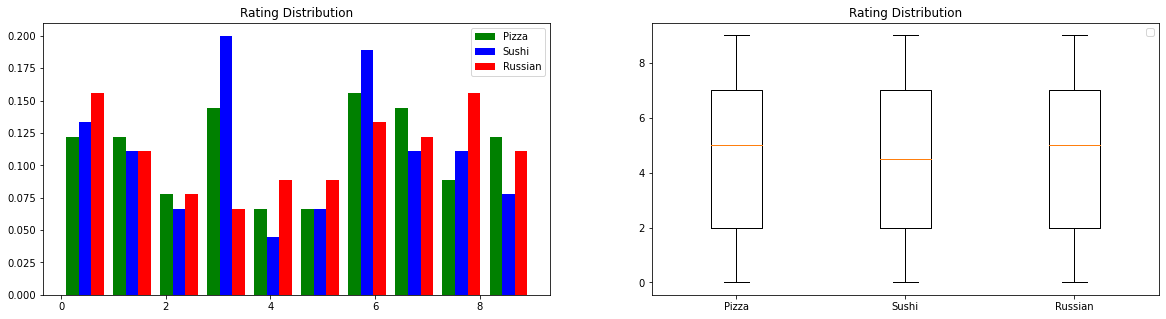

In [23]:
histdata = [df_pizza['Rating'],df_sushi['Rating'],df_rus['Rating']]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax0, ax1 = axes.flatten()

colors = ['green', 'blue', 'red']
ax0.hist(histdata, 10, density=True, histtype='bar', color=colors, label=['Pizza', 'Sushi', 'Russian'])
ax0.legend(prop={'size': 10})
ax0.set_title('Rating Distribution')

colors = ['green', 'blue', 'red']
ax1.boxplot(histdata, labels=['Pizza', 'Sushi', 'Russian'])
ax1.legend(prop={'size': 10})
ax1.set_title('Rating Distribution')

plt.show()

### Let's compare average tips

No handles with labels found to put in legend.


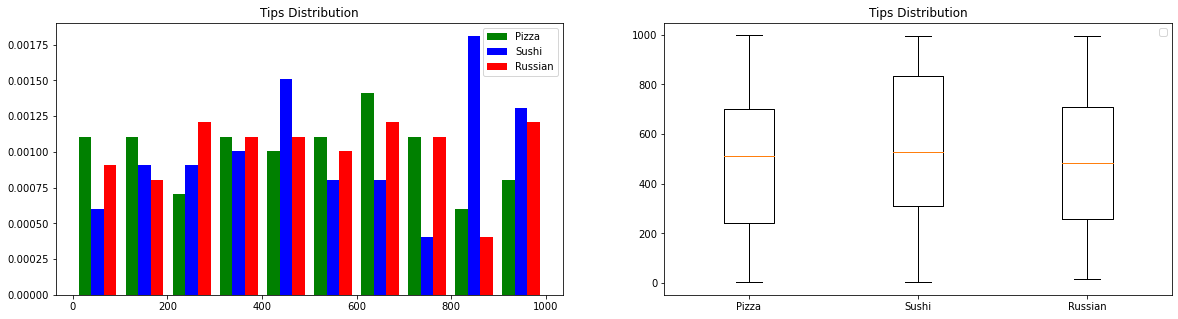

In [24]:
histdata = [df_pizza['Tips'] * tips_pizza_max, df_sushi['Tips'] * tips_sushi_max, df_rus['Tips'] * tips_rus_max]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax0, ax1 = axes.flatten()

colors = ['green', 'blue', 'red']
ax0.hist(histdata, 10, density=True, histtype='bar', color=colors, label=['Pizza', 'Sushi', 'Russian'])
ax0.legend(prop={'size': 10})
ax0.set_title('Tips Distribution')

colors = ['green', 'blue', 'red']
ax1.boxplot(histdata, labels=['Pizza', 'Sushi', 'Russian'])
ax1.legend(prop={'size': 10})
ax1.set_title('Tips Distribution')


plt.show()

### We can see the distribution of ratings and tips. Let's now see the averages

In [25]:
mean_pizza = df_pizza['Rating'].mean()
mean_sushi = df_sushi['Rating'].mean()
mean_rus = df_rus['Rating'].mean()

print("Average rating for pizza = " + str(mean_pizza))
print("Average rating for sushi = " + str(mean_sushi))
print("Average rating for Russian = " + str(mean_rus))

list_dfs = [df_pizza, df_sushi, df_rus]
list_means = [mean_pizza, mean_sushi, mean_rus]

df_target = list_dfs[list_means.index(max(list_means))]

Average rating for pizza = 4.56
Average rating for sushi = 4.37
Average rating for Russian = 4.65


### Let's also compare Tips

In [26]:
print("Average tips for pizza = " + str(df_pizza['Tips'].mean() * tips_pizza_max))
print("Average tips for sushi = " + str(df_sushi['Tips'].mean() * tips_sushi_max))
print("Average tips for Russian = " + str(df_rus['Tips'].mean() * tips_rus_max))

Average tips for pizza = 486.6900000000001
Average tips for sushi = 549.8400000000001
Average tips for Russian = 496.8599999999999


## From the analysis above we see that Russian restraunts are more popular, thus likely to be invested in
### Let's now cluster them and display on the map

In [27]:
kclusters = 7
dfKM = df_target.drop('Name', 1).drop('Short', 1).drop('Category', 1).drop('Likes', 1).drop('Tips', 1).drop('ID', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfKM)

# check cluster labels generated for each row in the dataframe
kmeans.cluster_centers_

array([[5.57596187e+01, 3.76054411e+01, 1.41176471e+00],
       [5.57528726e+01, 3.76215652e+01, 7.00000000e+00],
       [5.57570996e+01, 3.76114472e+01, 3.57142857e+00],
       [5.57640012e+01, 3.75923141e+01, 9.00000000e+00],
       [5.57629221e+01, 3.76086981e+01, 8.00000000e+00],
       [5.57582121e+01, 3.76063594e+01, 5.60000000e+00],
       [5.57545578e+01, 3.76182934e+01, 8.88178420e-16]])

In [31]:
map_clusters = folium.Map(location=[msk_lat,msk_lon], zoom_start=zoom-1)

add_circles(df_target, map_clusters, 'red', 'Rating', 1)
# add markers to the map
markers_colors = []
for lat, lon, sz in zip(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2]):
    folium.CircleMarker(
        [lat, lon],
        radius=sz+5,
        popup=str(sz),
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## This map presents the most desireable areas and places to invest